<a href="https://colab.research.google.com/github/ThulioSilva13/ProjetoCienciaDeDados/blob/main/TPDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Descrição do projeto**
> O projeto tem o foco em desenvolver um modelo capaz de medir a taxa de evasão dos alunos do curso de Ciência da Computação da Universidade Federal de Viçosa - Campus Florestal,  onde são classificados de acordo com alguns parâmetros como idade, gênero, data de ingresso no curso, raça, cidade onde vivia antes de se mudar para as aulas, nota obtida no ENEM, CRA, modalidade de ingresso e o número de reprovações.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Bibliotecas utilizadas**

In [ ]:
!pip install python-Levenshtein
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### NÃO REMOVA ESSA CÉLULA!! ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import chi2_contingency
import scipy.stats as stats
import statsmodels.stats.proportion as proportion
import seaborn as sns

## **Leitura dos dados**

In [ ]:
# dados = pd.read_csv('/content/drive/MyDrive/CienciaDeDados/dadosEstudantesUFV.csv', header = 0)
# dados

dados = pd.read_csv('./dadosEstudantesUFV.csv')
dados

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
0,29271,1982.0,M,CAV,1101,CAV - Administração,RJ,VOLTA REDONDA,2000/1,2000/1,A,Abandono ...,Evasão,0.0,NaN,0,Informação não disponível,0
1,29272,1982.0,M,CAV,1101,CAV - Administração,DF,Brasília,2000/1,2002/1,A,Abandono ...,Evasão,0.0,NaN,3,Informação não disponível,"71,2"
2,34462,1979.0,F,CAV,1101,CAV - Administração,MG,Viçosa,2000/1,2005/1,C,Conclusão ...,Conclusão,0.0,NaN,3,Informação não disponível,"78,5"
3,34468,1979.0,F,CAV,1101,CAV - Administração,MG,Belo Horizonte,2000/1,2006/1,C,Conclusão ...,Conclusão,0.0,NaN,20,Pardo(a),56
4,34470,1980.0,F,CAV,1101,CAV - Administração,SP,São Paulo,2000/1,2004/2,C,Conclusão ...,Conclusão,0.0,NaN,1,Informação não disponível,"76,9"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74021,172112,1996.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,NaN,2023/1,0,N,Normal ...,Matriculado,0.0,NaN,0,Informação não disponível,0
74022,172110,1995.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,NaN,2023/1,0,N,Normal ...,Matriculado,0.0,NaN,0,Informação não disponível,NaN
74023,172113,1996.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,NaN,2023/1,0,N,Normal ...,Matriculado,0.0,NaN,0,Informação não disponível,NaN
74024,172114,1998.0,NaN,CAV,1153,CAV - Bacharelado em Educação Física,NaN,NaN,2023/1,0,N,Normal ...,Matriculado,0.0,NaN,0,Informação não disponível,NaN


## **Análise inicial dos dados**


> Inicialmente foi feita uma análise inicial dos atributos, observando fatores como o nome da coluna, o tipo de dado, os valores, dentre outros aspectos. Abaixo são listadas as observações:

> 1. Ao analisar os dados, percebeu-se que alguns possuem incompatibilidade em alguns campos, como por exemplo:
 - Não são todos os alunos que possuem valores na coluna contendo a nota do ENEM
 - Alguns campos que deveriam ter o preenchimento obrigatório, como as colunas Sexo e UF_Nascimento, estão valores NaN.
  - Alguns alunos possuem modalidade de ingresso com valor igual a zero. Desse modo, após pesquisar sobre o significado da modadlidade 0, descobriu-se que se refere ao campo de "Ampla Concorrência", entretanto, o valor de modalidade 9 também se refere a esse mesmo campo. Portanto, vale observar essa semelhança entre os dados para que futuramente no projeto evite falhas na observação e conclusão na análise desses dados.

> 2. Outra observação realizada, foi a relação entre a modalidade de ingresso e a nota obtida no ENEM, alguns alunos tem o campo preenchido com a nota do ENEM que usaram quando entraram na universidade, mas porém não consta em qual modalidade ele foi classificado. O mesmo se aplica no caso contrário, alguns alunos não possuem a nota do ENEM, mas na coluna da modalidade de ingresso, consta um valor.

> 3. Ao examinarmos o campo Situacao_Aluno, é possível perceber que ele possui diversos tipos de valores, como por exemplo, Conclusão, Desligamento, Abandono, Transferência, entre outros. Já ao observarmos o campo Situacao_Aluno_Agrupado, os valores se resumem a Conclusão, Evasão, Retenção e Matriculado. Após análises, percebeu-se que uma coluna tem relação direta com a outra, pois:
  - O valor Conclusão no campo Situacao_Aluno_Agrupado, se refere também aos valores Conclusão de Situacao_Aluno que indicam que o aluno concluiu o curso
  - Evasão corresponde aos alunos que abandonaram o curso
  - Matriculado caracteriza os alunos que ainda estão cursando
  - Retenção se refere aos alunos que ainda estão cursando, mas que por algum motivo, não estão tendo aulas

>   Foi concluído então que o campo Situacao_Aluno_Agrupado é uma versão resumida do campo Situacao_Aluno, com valores agrupados que indicam a situação atual do aluno no curso. Essa análise é importante para compreender melhor os dados e para tomar decisões com base nessas informações, além de que entender a relação entre as diferentes colunas pode ajudar a identificar tendências.

## **Perguntas que guiarão o projeto**

> Inicialmente, existem 9 perguntas que guiarão o projeto e que pretendemos responder durante o desenvolvimento do modelo, sendo elas:

 1.  O CRA segue uma distribuição normal?

 2. Avaliar se o gênero influencia na evasão através de análises da porcentagem de meninas que evadiram em comparação com o valor percentual de meninos que evadiram.

 3. Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

 4. Os alunos que vieram de escolas públicas tendem a abandonar o curso?

 5. Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

 6. Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

 7. Existe alguma relação entre a nota do ENEM e a evasão do curso?

 8. É possível afirmar que os alunos abandonam o curso por serem de algum estado diferente de Minas Gerais, onde o campus se localiza?

 9. Através do cálculo da média do CRA dos alunos de Ciência da Computação, esperamos ser possível classificar se uma amostra pertence ou não a população que representa os alunos do curso citado.

## **Formatação e limpeza dos dados**

Essa etapa envolve entender os atributos e objetos dos dados, os tipos de cada atributo, o domínio de cada atributo,
verificar e identificar possíveis ruídos ou informações ausentes, criar novos atributos se necessário, formatar valores, juntar conjuntos de dados, dentre outras atividades.

In [ ]:
df = dados
print(df.columns.values)

###Função para padronizar o texto, removendo acentos e caixa alta.

In [ ]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

###Função para padronizar nomes semelhantes e corrigir pequenos erros de ortografia, a fim de transformá-los em um único nome. Por exemplo, ela pode ser usada para converter "vcosa" em "vicosa".

In [ ]:
def standardize_strings(column, threshold=80):
    standardized_strings = []
    for string in column:
        standardized = False
        for standard in standardized_strings:
            similarity = fuzz.ratio(string, standard)
            if similarity >= threshold:
                column.replace(string, standard, inplace=True)
                standardized = True
                break

        if not standardized:
            standardized_strings.append(string)

    return column

###Funções para padronizar algumas entradas especificas como por exemplo:

física e física - Licenciatura
vicosa - mg em vicosa

In [ ]:
def merge_entries(course_name):
    if course_name.endswith(' - Licenciatura'):
        return course_name[:-len(' - Licenciatura')]
    else:
        return course_name

def remove_suffix(entry):
    return entry.split(' - ')[0]

####Removendo valores nulos e valores que não fazem sentido, como por exemplo um aluno no curso superior que nasceu depois de 2015

In [ ]:
df = df.dropna()
df = df[df["Ano_Nascimento"] < 2015]
df= df[df["UF_Nascimento"] != " "]

####Removendo acentos, espaços e caixa alta

In [ ]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(lambda x: strip_accents(x).strip().lower())
df['Situacao_Aluno'] = df['Situacao_Aluno'].apply(lambda x: strip_accents(x).strip().lower())

####Unindo cursos de licenciatura com sufixo específico ' - Licenciatura'  proprio de cursos em Florestal

In [ ]:
df['Curso'] = df['Curso'].apply(merge_entries)
df['Curso'] = df['Curso'].apply(lambda x: x.strip())

####renomeia municipios com sufixos de estado
ex "vicosa", "vicosa - mg"

In [ ]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(remove_suffix)

####Filtra o dataframe para deixar apenas os alunos que evadiram ou formaram

In [ ]:
df_filtro = df[(df["Situacao_Aluno_Agrupada"] == "Conclusão") | (df["Situacao_Aluno_Agrupada"] == "Evasão")]


####une municipios de nome similar a partir de threshold
ex: "vcosa", "vicosa"

In [ ]:
standardized_column = standardize_strings(df['Municipio_Nascimento'], threshold=80)
df['Municipio_Nascimento'] = standardized_column

## **Estatísticas descritivas sobre os dados**


In [ ]:
df_filtro

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
24387,77400,1991.0,F,CAV,1143,CAV - Licenciatura em Física,SP,sao paulo,2010/1,2010/1,M,mudanca de curso,Evasão,0.0,"676,98",0,Pardo(a),"67,3"
24388,77416,1992.0,M,CAV,1143,CAV - Licenciatura em Física,MG,vicosa,2010/1,2010/1,A,abandono,Evasão,0.0,"611,82",5,Branco(a),0
24389,77422,1989.0,M,CAV,1143,CAV - Licenciatura em Física,MG,vicosa,2010/1,2011/2,D,desligamento,Evasão,0.0,"591,1",15,Informação não disponível,"28,8"
24404,77455,1992.0,M,CAV,1144,CAV - Licenciatura em Matemática,MG,vicosa,2010/1,2010/2,A,abandono,Evasão,0.0,"629,98",7,Preto(a),"10,2"
24405,77463,1992.0,M,CAV,1144,CAV - Licenciatura em Matemática,MG,uba,2010/1,2015/2,C,conclusao,Conclusão,0.0,"628,06",2,Branco(a),83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73710,30010218,2003.0,M,CRP,3105,CRP - Sistemas de Informação - Noturno,MG,formiga,2022/1,2022/2,A,estudante em abandono de curso,Evasão,9.0,"629,76",1,Branco(a),"68,7"
73711,30010230,2003.0,M,CRP,3105,CRP - Sistemas de Informação - Noturno,MG,alvinopolis,2022/1,2022/1,A,estudante em abandono de curso,Evasão,5.0,"605,3",4,Pardo(a),"4,4"
73842,171075,1974.0,F,CAV,1132,CAV - Geografia,MG,piranga,2022/2,2022/2,A,abandono,Evasão,0.0,"478,48",0,Pardo(a),0
73882,171070,1995.0,F,CAV,1132,CAV - Geografia,MG,vicosa,2022/2,2022/2,A,abandono,Evasão,0.0,"537,48",0,Preto(a),0


In [ ]:
df_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24434 entries, 24387 to 73905
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            24434 non-null  int64  
 1   Ano_Nascimento           24434 non-null  float64
 2   Sexo                     24434 non-null  object 
 3   Campus                   24434 non-null  object 
 4   Curso_Identificador      24434 non-null  int64  
 5   Curso                    24434 non-null  object 
 6   UF_Nascimento            24434 non-null  object 
 7   Municipio_Nascimento     24434 non-null  object 
 8   Admissao                 24434 non-null  object 
 9   Saida                    24434 non-null  object 
 10  Codigo_Situacao_Aluno    24434 non-null  object 
 11  Situacao_Aluno           24434 non-null  object 
 12  Situacao_Aluno_Agrupada  24434 non-null  object 
 13  Modalidade_Inscrita      24434 non-null  float64
 14  ENEM              

In [ ]:
dados = df[(df['Curso'] == 'CAF - Ciência da Computação') | (df['Curso'] == 'CAV - Ciência da Computação') | (df['Curso'] == 'C - Ciência da Computação')]
dados

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
28759,84207,1989.0,M,CAV,1141,CAV - Ciência da Computação,MG,visconde do rio branco,2011/1,2014/1,C,conclusao,Conclusão,0.0,"725,66",0,Pardo(a),78
28767,81982,1990.0,F,CAV,1141,CAV - Ciência da Computação,SP,sao paulo,2011/1,2016/1,C,conclusao,Conclusão,0.0,"640,86",10,Pardo(a),"63,2"
28817,85304,1991.0,F,CAV,1141,CAV - Ciência da Computação,MG,vicosa,2011/1,2014/2,C,conclusao,Conclusão,0.0,"672,7",0,Preto(a),"79,2"
28818,81981,1993.0,M,CAV,1141,CAV - Ciência da Computação,MG,uba,2011/1,2015/2,C,conclusao,Conclusão,0.0,"671,4",9,Branco(a),"68,9"
28905,81983,1993.0,M,CAV,1141,CAV - Ciência da Computação,MG,itabira,2011/1,2016/2,C,conclusao,Conclusão,0.0,"639,5",17,Branco(a),"53,2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73320,20006536,2004.0,M,CAF,2107,CAF - Ciência da Computação,MG,turmalina,2022/1,0,N,normal,Matriculado,5.0,"622,3",0,Pardo(a),"75,1"
73321,20006538,2002.0,F,CAF,2107,CAF - Ciência da Computação,MG,patos de minas,2022/1,2022/1,A,abandono,Evasão,1.0,"554,82",4,Pardo(a),0
73944,20006972,1995.0,M,CAF,2107,CAF - Ciência da Computação,MG,porteirinha,2022/2,0,N,normal,Matriculado,0.0,"656,38",0,Indígena,0
73951,20006987,1997.0,M,CAF,2107,CAF - Ciência da Computação,MG,belo horizonte,2022/2,0,N,normal,Matriculado,0.0,"644,9",0,Branco(a),0


## **Pergunta 1**: O CRA segue uma distribuição normal?

In [ ]:
from scipy import stats
df_cdc = dados[dados['Curso'] == "CAF - Ciência da Computação"]

Foi utilizado diferentes algoritmos para calcular o p-value

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_cdc['CRA'] = df_cdc['CRA'].dropna()
df_cdc['CRA'] = df_cdc['CRA'].astype(str)
df_cdc['CRA'] = df_cdc['CRA'].str.replace(',', '.')
df_cdc['CRA']

df_cdc['CRA']  = df_cdc['CRA'].astype(float)

print("\n====== Algoritmo: Kolmogorov-Smirnov ======\n")
stat, p_value = stats.kstest(df_cdc['CRA'], 'norm')
print('Estatística de teste:', stat)
print('Valor p:', p_value)

print("\n====== Algoritmo: Anderson ======\n")
result = stats.anderson(df_cdc['CRA'], dist='norm')
print('Estatística de teste:', result.statistic)
print('Valores críticos:', result.critical_values)
print('Níveis de significância:', result.significance_level)

print("\n====== Algoritmo: Jarque Bera ======\n")
stat_jb, p_value_jb = stats.jarque_bera(df_cdc['CRA'])
print('Estatística de teste:', stat_jb)
print('Valor p:', p_value_jb)
# normalidade_CRA = stats.shapiro(df_cdc_cdc_CRA)

from statsmodels.stats.diagnostic import lilliefors
print("\n====== Algoritmo: Lilliefors ======\n")
# Realizar o teste de Lilliefors
stat_l, p_value_l = lilliefors(df_cdc['CRA'])

# Imprimir os resultados
print('Estatística de teste:', stat_l)
print('Valor p:', p_value_l)

# print("P-Value: ", normalidade_CRA)

print("\n====== Média CRA ======\n")
#Media CRA
print("Media CRA => ", df_cdc['CRA'].mean())


====== Algoritmo: Kolmogorov-Smirnov ======

Estatística de teste: 0.8962878972439604
Valor p: 0.0

====== Algoritmo: Anderson ======

Estatística de teste: 10.888585154800467
Valores críticos: [0.572 0.651 0.781 0.911 1.084]
Níveis de significância: [15.  10.   5.   2.5  1. ]

====== Algoritmo: Jarque Bera ======

Estatística de teste: 38.01973929428319
Valor p: 5.547770802164586e-09

====== Algoritmo: Lilliefors ======

Estatística de teste: 0.09856523997110211
Valor p: 0.0009999999999998899

====== Média CRA ======

Media CRA =>  49.519881889763774


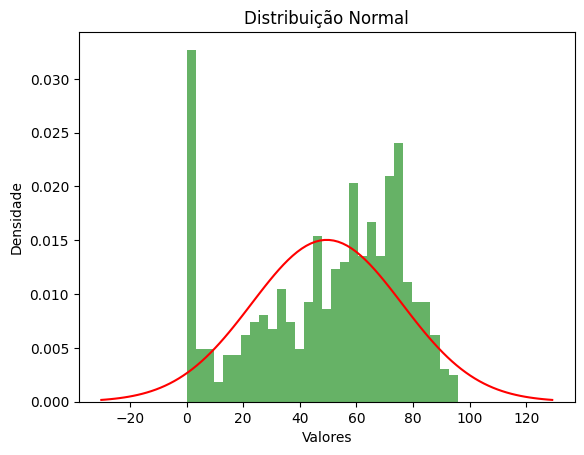

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc['CRA']), np.std(df_cdc['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()


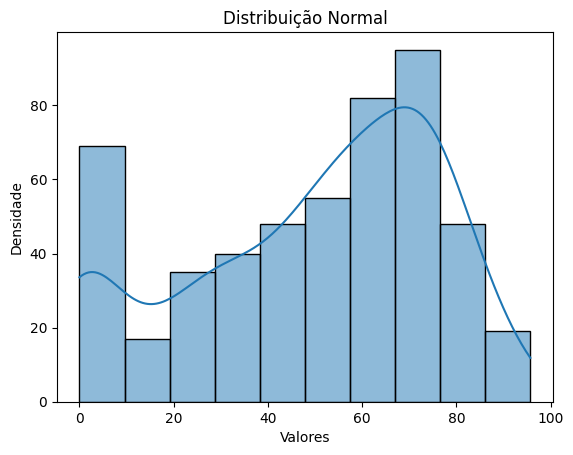

In [ ]:
sns.histplot(df_cdc['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

A partir desse resultado, percebeu-se que o padrão está desacordo com a distribuição normal.

A partir disso, foi pensado que se os valores de CRA igual a 0 fossem retirados, poderia melhorar a distribuição:

In [ ]:
df_cdc_CRA_diferente_zero = df_cdc[df_cdc['CRA'] != 0]

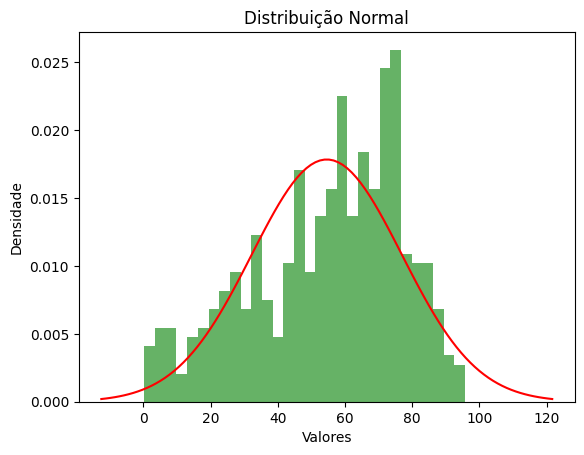

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc_CRA_diferente_zero['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc_CRA_diferente_zero['CRA']), np.std(df_cdc_CRA_diferente_zero['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()

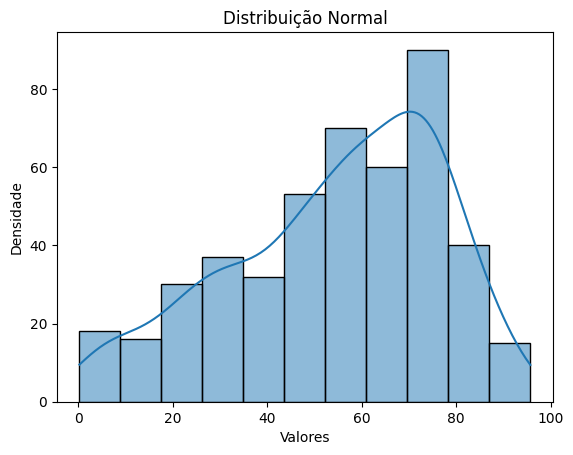

In [ ]:
sns.histplot(df_cdc_CRA_diferente_zero['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

Entretanto, mesmo retirando os valores iguais a 0, a distribuição não segue uma normalidade, portanto, isso significa que eles não possuem a forma de sino simétrica típica da distribuição normal

## **Pergunta 2**: Avaliar se o gênero influencia na evasão através de análises da porcentagem de meninas que evadiram em comparação com o valor percentual de meninos que evadiram.

In [ ]:
df_meninas_evasao = dados[(dados['Sexo'] == 'F')]
df_meninos_evasao = dados[dados['Sexo'] == 'M']

In [ ]:
quantidade_total_meninas = df_meninas_evasao['Sexo'].shape[0]
quantidade_total_meninos = df_meninos_evasao['Sexo'].shape[0]

quantidade_meninas_evadiram = df_meninas_evasao[df_meninas_evasao['Situacao_Aluno_Agrupada'] == 'Evasão'].shape[0]
quantidade_meninos_evadiram = df_meninos_evasao[df_meninos_evasao['Situacao_Aluno_Agrupada'] == 'Evasão'].shape[0]

quantidade_meninas_concluiram = df_meninas_evasao[df_meninas_evasao['Situacao_Aluno_Agrupada'] == 'Conclusão'].shape[0]
quantidade_meninos_concluiram = df_meninos_evasao[df_meninos_evasao['Situacao_Aluno_Agrupada'] == 'Conclusão'].shape[0]

perc_meninas_evadiram = (quantidade_meninas_evadiram / quantidade_total_meninas) * 100
perc_meninos_evadiram = (quantidade_meninos_evadiram / quantidade_total_meninos) * 100

print(f'A quantidade total de meninos: {quantidade_total_meninos}')
print(f'A quantidade total de meninas: {quantidade_total_meninas}\n')

print(f'A quantidade de meninos que evadiram: {quantidade_meninos_evadiram}')
print(f'A quantidade de meninas que evadiram: {quantidade_meninas_evadiram}\n')

print(f'A quantidade de meninos que concluiram: {quantidade_meninos_concluiram}')
print(f'A quantidade de meninas que concluiram: {quantidade_meninas_concluiram}\n')

print(f'Porcentagem de meninos que evadiram: {perc_meninos_evadiram:.2f}%')
print(f'Porcentagem de meninas que evadiram: {perc_meninas_evadiram:.2f}%')

A quantidade total de meninos: 863
A quantidade total de meninas: 136

A quantidade de meninos que evadiram: 392
A quantidade de meninas que evadiram: 52

A quantidade de meninos que concluiram: 158
A quantidade de meninas que concluiram: 26

Porcentagem de meninos que evadiram: 45.42%
Porcentagem de meninas que evadiram: 38.24%


In [ ]:
# Teste de proporções z
count = np.array([quantidade_meninas_evadiram, quantidade_meninos_evadiram])
nobs = np.array([quantidade_total_meninas, quantidade_total_meninos])
z_score, p_value = proportion.proportions_ztest(count, nobs, alternative='smaller')

# Define a hipótese nula e nível de significância
alpha = 0.05
h0 = "As meninas não têm uma proporção de evasão maior do que os meninos."

# Verifica se rejeita ou não a hipótese nula
if p_value < alpha:
    print("Rejeitamos a hipótese nula.")
    print("Há evidências de que as meninas têm uma proporção de evasão maior do que os meninos.")
else:
    print("Não rejeitamos a hipótese nula.")
    print("Não há evidências suficientes para afirmar que as meninas têm uma proporção de evasão maior do que os meninos.")

Não rejeitamos a hipótese nula.
Não há evidências suficientes para afirmar que as meninas têm uma proporção de evasão maior do que os meninos.


> Após realizar o cálculo de algumas estatísticas descritivas e do teste de hipóteses, concluímos que não há evidências de que meninas evadem mais que meninos.

## **Pergunta 3**: Número médio de alunos que ingressaram no curso durante a pandemia de COVID-19, onde se espera entender se o método de ensino remoto influenciou ou não na decisão de saída do curso.

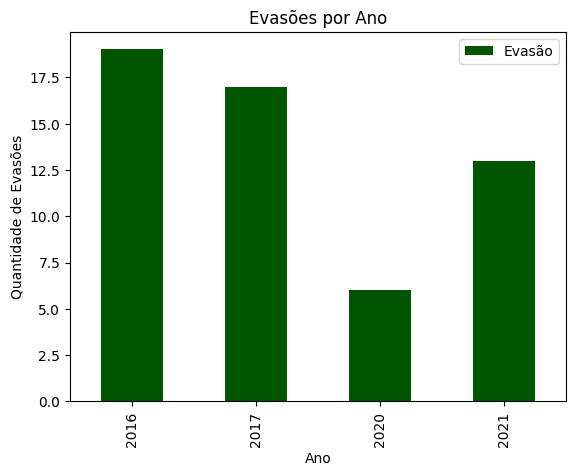

In [ ]:
admitido2016 = df_cdc[df_cdc['Admissao'].str.contains("2016")]
admitido2017 = df_cdc[df_cdc['Admissao'].str.contains("2017")]
admitido2020 = df_cdc[df_cdc['Admissao'].str.contains("2020")]
admitido2021 = df_cdc[df_cdc['Admissao'].str.contains("2021")]

evasao2016 = admitido2016[(admitido2016['Saida'].str.contains("2016")) | (admitido2016['Saida'].str.contains("2017"))].count()['Saida']
evasao2017 = admitido2017[(admitido2017['Saida'].str.contains("2017")) | (admitido2017['Saida'].str.contains("2018"))].count()['Saida']
evasao2020 = admitido2020[(admitido2020['Saida'].str.contains("2020")) | (admitido2020['Saida'].str.contains("2021"))].count()['Saida']
evasao2021 = admitido2021[(admitido2021['Saida'].str.contains("2021")) | (admitido2021['Saida'].str.contains("2022"))].count()['Saida']

data = {'Ano': ['2016', '2017', '2020', '2021'],
        'Evasão': [evasao2016, evasao2017, evasao2020, evasao2021]}
df_evasao = pd.DataFrame(data)

df_evasao.plot(x='Ano', y='Evasão', kind='bar', color='#005500')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Evasões')
plt.title('Evasões por Ano')
plt.show()


## **Pergunta 4:** Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

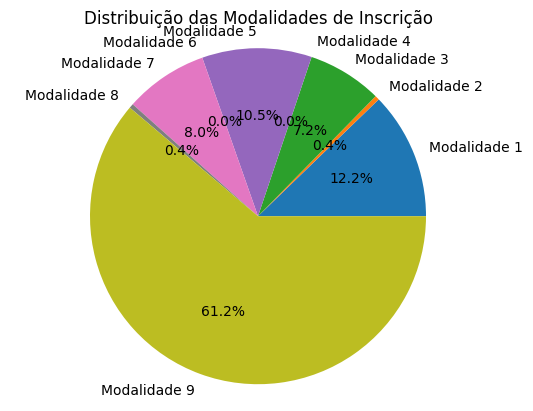

In [ ]:
modalidade1 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 1) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade2 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 2) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade3 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 3) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade4 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 4) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade5 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 5) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade6 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 6) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade7 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 7) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade8 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 8) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade9 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 9) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()

modalidades = [modalidade1[0], modalidade2[0], modalidade3[0], modalidade4[0],
               modalidade5[0], modalidade6[0], modalidade7[0], modalidade8[0], modalidade9[0]]

labels = ['Modalidade 1', 'Modalidade 2', 'Modalidade 3', 'Modalidade 4',
          'Modalidade 5', 'Modalidade 6', 'Modalidade 7', 'Modalidade 8', 'Modalidade 9']

plt.pie(modalidades, labels=labels, autopct='%1.1f%%')
plt.title('Distribuição das Modalidades de Inscrição')
plt.axis('equal')
plt.show()

## **Pergunta 5:** Os alunos que vieram de escolas públicas tendem a abandonar o curso?

In [ ]:
df_cdc_modalidade = df_cdc.groupby('Modalidade_Inscrita').count()

qntdTotal_modalidade9 = df_cdc_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 no curso inteiro: ",qntdTotal_modalidade9)

qntdTotal_modalidades1_a_8 = df_cdc_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro: ",qntdTotal_modalidades1_a_8)


df_cdc_modalidade

Quantidade total de pessoas da modalidade 9 no curso inteiro:  280
Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro:  234


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,10,10,10,10,10,10,10,10,10,10,10,10,10,4,10,10,10
1.0,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55
5.0,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65
7.0,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,280,280,280,280,280,280,280,280,280,280,280,280,280,270,280,280,280


In [ ]:
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono_modalidade = df_cdc_abandono.groupby('Modalidade_Inscrita').count()

qntdTotal_abandono_modalidade9 = df_cdc_abandono_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 que abandonaram o curso: ",qntdTotal_abandono_modalidade9)

qntdTotal_abandono_modalidades1_a_8 = df_cdc_abandono_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso: ",qntdTotal_abandono_modalidades1_a_8)

df_cdc_abandono_modalidade

Quantidade total de pessoas da modalidade 9 que abandonaram o curso:  103
Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso:  64


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
1.0,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
5.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
7.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,103,103,103,103,103,103,103,103,103,103,103,103,103,99,103,103,103


In [ ]:
porcentagem_modalidade9 = (qntdTotal_abandono_modalidade9/qntdTotal_modalidade9) * 100

porcentagem_modalidade1_a_8 = (qntdTotal_abandono_modalidades1_a_8/qntdTotal_modalidades1_a_8)  * 100

print("Porcentagem de pessoas que abandonaram o curso da modalidade 9:", porcentagem_modalidade9,"%\n")
print("Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8:", porcentagem_modalidade1_a_8,"%\n")

Porcentagem de pessoas que abandonaram o curso da modalidade 9: 36.78571428571429 %

Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8: 27.350427350427353 %



De acordo com os dados calculados, não necessariamente as pessoas que vieram de escola pública tendem a abandonar o curso, pois, analisando os dados, em torno de 280 alunos que entraram pela ampla concorrência, 103, ou seja, 36.80% abandonaram o curso, em contrapartida, de 234 alunos que entraram pelas modalidades inclusivas de escolas públicas, apenas 64, ou seja, 27.40% abandonaram o curso.

## **Pergunta 6**: Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

In [ ]:
df_alunos_evadiram = dados[dados['Situacao_Aluno_Agrupada'] == 'Evasão']

In [ ]:
# Converter a coluna de object para int
df_alunos_evadiram['Num_Reprovacoes'] = df_alunos_evadiram['Num_Reprovacoes'].astype(int)

<ipython-input-14-a142909832e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alunos_evadiram['Num_Reprovacoes'] = df_alunos_evadiram['Num_Reprovacoes'].astype(int)


In [ ]:
# Calcular a frequência dos valores de reprovações
frequencia_reprovacoes = df_alunos_evadiram['Num_Reprovacoes'].value_counts().sort_index()

# Imprimir a tabela de frequência
print(f'Tabela de Frequência das Reprovações:')
print(f'(Número de reprovações/Quantidade de alunos)')
print(frequencia_reprovacoes)

Tabela de Frequência das Reprovações:
(Número de reprovações/Quantidade de alunos)
0     13
1     17
2     22
3     22
4     44
5     64
6     30
7     29
8     20
9     33
10    24
11    25
12    15
13    16
14    15
15    13
16     8
17    10
18     9
19     4
20     4
21     1
22     2
23     1
25     2
27     1
Name: Num_Reprovacoes, dtype: int64


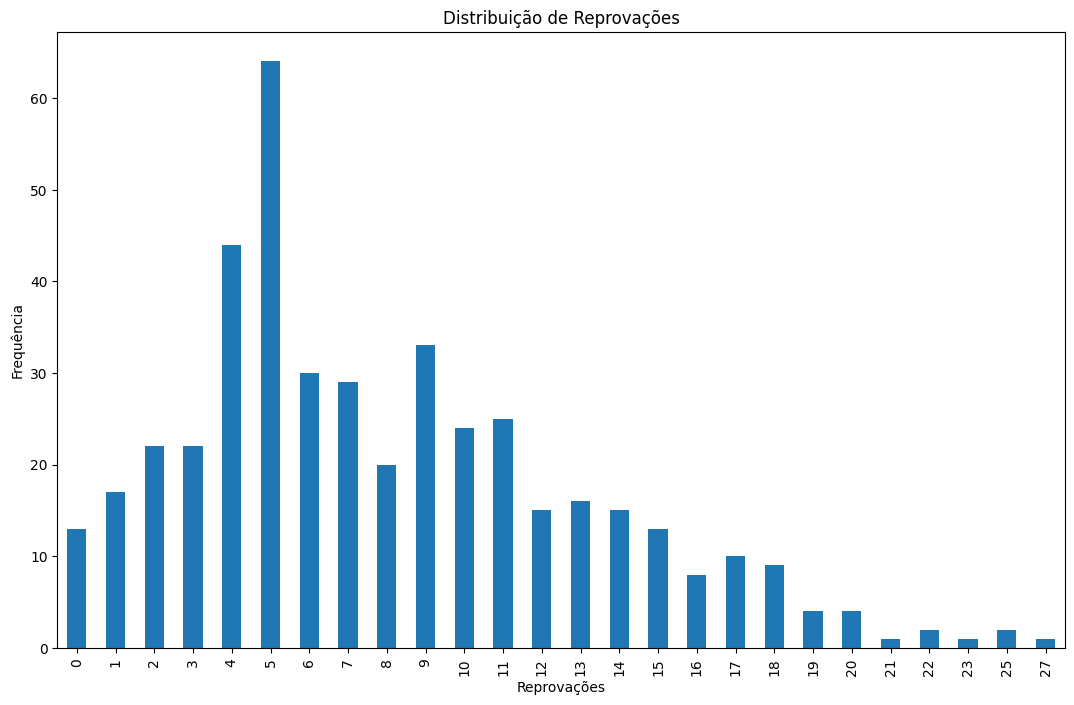

In [ ]:
plt.figure(figsize=(13, 8))
frequencia_reprovacoes.plot(kind='bar')
plt.xlabel('Reprovações')
plt.ylabel('Frequência')
plt.title('Distribuição de Reprovações')
plt.show()

> Podemos observar um pico na frequência em torno de 5 reprovações e uma tendência de diminuição à medida que o número de reprovações aumenta ou diminui em relação a esse pico. Isso pode indicar que a maioria dos alunos que evadiu apresentava em torno de 5 reprovações.

## **Pergunta 7**: Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def remove_suffix1(entry):
    return entry.split('/1')[0]
def remove_suffix2(entry):
    return entry.split('/2')[0]
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix1)
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix2)

df_cdc_abandono = df_cdc_abandono[df_cdc_abandono['Saida'] != 0]
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].astype(float)
df_cdc_abandono['IdadeAbandono'] = df_cdc_abandono['Saida'] - df_cdc_abandono['Ano_Nascimento']

media = df_cdc_abandono['IdadeAbandono'].mean()
print("Média da idade das pessoas que abandonaram o curso: ",media)

groupIdade = df_cdc_abandono.groupby('IdadeAbandono').count()

qntdIdade18_a_21 = groupIdade.head(4).sum()
somaIdades = groupIdade.sum()[0]

porcentagem_18_a_21 = (qntdIdade18_a_21/somaIdades) * 100
print("Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos:", porcentagem_18_a_21[0],"%\n")
groupIdade


Média da idade das pessoas que abandonaram o curso:  21.378238341968913
Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos: 70.46632124352331 %



,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
IdadeAbandono,,,,,,,,,,,,,,,,,,
18.0,43,43,43,43,43,43,43,43,43,43,43,43,43,36,43,43,43,43
19.0,41,41,41,41,41,41,41,41,41,41,41,41,41,41,39,41,41,41
20.0,28,28,28,28,28,28,28,28,28,28,28,28,28,25,26,28,28,28
21.0,24,24,24,24,24,24,24,24,24,24,24,24,24,20,23,24,24,24
22.0,12,12,12,12,12,12,12,12,12,12,12,12,12,11,12,12,12,12
23.0,11,11,11,11,11,11,11,11,11,11,11,11,11,10,11,11,11,11
24.0,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10
25.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
26.0,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3


Vale analisar que a média da idade das pessoas que abandonaram o curso é de 21 anos.

A quantidade de pessoas mais novas que abandonam o curso, por cerca de 18,19,20 e 21 são bem maiores do que as pessoas maiores de 23 anos, visto que, pelos cálculos, há 136 pessoas que abandonaram o curso estando nessas faixas de idade, em torno de 70.46% do total que abandonaram. Portanto, vale analisar, por meio desses dados, que as pessoas da faixa etária de jovens-adultos são os alunos que mais tendem a abandonar o curso.

## **Pergunta 8:**  Existe alguma relação entre a nota do ENEM e a evasão do curso?

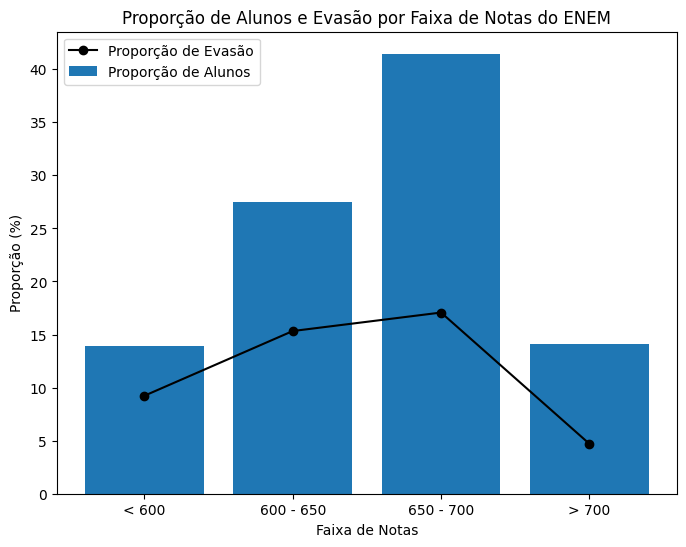

In [ ]:
evasao = df_cdc[(df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')]
notaMenor600 = df_cdc[df_cdc['ENEM'] < '600']
nota600e650 = df_cdc[(df_cdc['ENEM'] >= '600') & (df_cdc['ENEM'] < '650')]
nota650e700 = df_cdc[(df_cdc['ENEM'] >= '650') & (df_cdc['ENEM'] < '700')]
notaMaior700 = df_cdc[df_cdc['ENEM'] > '700']

evasaoNotaMenor600 = evasao[evasao['ENEM'] < '600']
evasaoNota600e650 = evasao[(evasao['ENEM'] >= '600') & (evasao['ENEM'] < '650')]
evasaoNota650e700 = evasao[(evasao['ENEM'] >= '650') & (evasao['ENEM'] < '700')]
evasaoNotaMaior700 = evasao[evasao['ENEM'] > '700']

total_alunos = len(df_cdc)
prop_nota_menor_600 = len(notaMenor600) / total_alunos * 100
prop_nota_600_650 = len(nota600e650) / total_alunos * 100
prop_nota_650_700 = len(nota650e700) / total_alunos * 100
prop_nota_maior_700 = len(notaMaior700) / total_alunos * 100
prop_evasao_nota_menor_600 = len(evasaoNotaMenor600) / total_alunos * 100
prop_evasao_nota_600_650 = len(evasaoNota600e650) / total_alunos * 100
prop_evasao_nota_650_700 = len(evasaoNota650e700) / total_alunos * 100
prop_evasao_nota_maior_700 = len(evasaoNotaMaior700) / total_alunos * 100

data = {'Faixa de Notas': ['< 600', '600 - 650', '650 - 700', '> 700'],
        'Proporção (%)': [prop_nota_menor_600, prop_nota_600_650, prop_nota_650_700, prop_nota_maior_700],
        'Proporção de Evasão (%)': [prop_evasao_nota_menor_600, prop_evasao_nota_600_650, prop_evasao_nota_650_700, prop_evasao_nota_maior_700]}
df_prop = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
plt.bar(df_prop['Faixa de Notas'], df_prop['Proporção (%)'], label='Proporção de Alunos')
plt.plot(df_prop['Faixa de Notas'], df_prop['Proporção de Evasão (%)'], color='black', marker='o', label='Proporção de Evasão')
plt.xlabel('Faixa de Notas')
plt.ylabel('Proporção (%)')
plt.title('Proporção de Alunos e Evasão por Faixa de Notas do ENEM')
plt.legend()
plt.show()


## **Pergunta 9**: É possível afirmar que os alunos abandonam o curso por serem de algum estado diferente de Minas Gerais, onde o campus se localiza

In [ ]:
df_alunos_evadiram

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
28948,81980,1992.0,M,CAV,1141,CAV - Ciência da Computação,MG,vicosa,2011/1,2012/2,D,desligamento,Evasão,0.0,680.44,11,Pardo(a),40.2
29606,81978,1993.0,M,CAV,1141,CAV - Ciência da Computação,MG,itabira,2011/1,2016/1,M,mudanca de curso,Evasão,0.0,712.72,22,Branco(a),47.9
32269,90734,1987.0,M,CAV,1141,CAV - Ciência da Computação,MG,governador valadares,2012/1,2012/1,A,abandono,Evasão,0.0,693.04,5,Branco(a),0.2
32378,88293,1994.0,M,CAV,1141,CAV - Ciência da Computação,MG,santos dumont,2012/1,2013/2,D,desligamento,Evasão,0.0,658.74,13,Branco(a),14.9
32656,88274,1994.0,M,CAV,1141,CAV - Ciência da Computação,MG,ponte nova,2012/1,2014/2,D,desligamento,Evasão,0.0,664.16,10,Branco(a),26.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73173,20006527,2004.0,M,CAF,2107,CAF - Ciência da Computação,MG,belo horizonte,2022/1,2022/1,A,abandono,Evasão,9.0,703.72,4,Pardo(a),0.0
73231,20006503,2000.0,M,CAF,2107,CAF - Ciência da Computação,MG,itabuna,2022/1,2022/1,D,desligamento,Evasão,9.0,702.88,4,Informação não disponível,0.0
73234,20006512,2003.0,M,CAF,2107,CAF - Ciência da Computação,MG,itabuna,2022/1,2022/1,A,abandono,Evasão,9.0,708.32,3,Branco(a),0.0
73317,20006510,1999.0,M,CAF,2107,CAF - Ciência da Computação,MG,pedra azul,2022/1,2022/1,D,desligamento,Evasão,9.0,705.76,4,Informação não disponível,0.0


In [ ]:
evasao_mg = df_alunos_evadiram[df_alunos_evadiram['UF_Nascimento'] == 'MG']
evasao_fora_mg = df_alunos_evadiram[df_alunos_evadiram['UF_Nascimento'] != 'MG']

quantidade_evasao_mg = evasao_mg.shape[0]
quantidade_evasao_fora_mg = evasao_fora_mg.shape[0]

quantidade_alunos_mg = dados[dados['UF_Nascimento'] == 'MG'].shape[0]
quantidade_alunos_fora_mg = dados[dados['UF_Nascimento'] != 'MG'].shape[0]

print(f'Quantidade de alunos que são do estado MG e evadiram: {quantidade_evasao_mg}')
print(f'Quantidade de alunos que são do estado MG: {quantidade_alunos_mg}\n')

print(f'Quantidade de alunos que não são do estado MG e evadiram: {quantidade_evasao_fora_mg}')
print(f'Quantidade de alunos que não são do estado MG: {quantidade_alunos_fora_mg}')

Quantidade de alunos que são do estado MG e evadiram: 379
Quantidade de alunos que são do estado MG: 848

Quantidade de alunos que não são do estado MG e evadiram: 65
Quantidade de alunos que não são do estado MG: 151


In [ ]:
perc_alunos_mg_evadiram = (quantidade_evasao_mg/quantidade_alunos_mg) * 100
perc_alunos_fora_mg_evadiram = (quantidade_evasao_fora_mg/quantidade_alunos_fora_mg) * 100

print(f'Percentual de alunos que são do estado de MG e evadiram: {perc_alunos_mg_evadiram:.2f}%')
print(f'Percentual de alunos que não são do estado de MG e evadiram: {perc_alunos_fora_mg_evadiram:.2f}%')

Percentual de alunos que são do estado de MG e evadiram: 44.69%
Percentual de alunos que não são do estado de MG e evadiram: 43.05%


> Com base nos percentuais acima, podemos observar que os alunos que são de MG evadem mais que os alunos que não são. Porém o número de alunos fora de MG é extremamente menor que o número dos que são. Então, o valor de 46.05% que evadem e não são de MG tem um peso maior, siginificando que quase metade dos alunos que vem de outros estados para estudar nos campus da UFV, evadem.